# 📈 Automação de Dashboard Financeiro

Este notebook documenta o processo de ETL (Extract, Transform, Load) criado para automatizar a atualização do painel de investimentos no Obsidian.

## 🎯 Objetivo
Ler arquivos exportados da B3 (Excel), consultar carteira em tempo real via Yahoo Finance e gerar um relatório Markdown com recomendações de rebalanceamento.

## 🛠️ Tecnologias Utilizadas
- **Python**: Linguagem principal.
- **Pandas**: Manipulação de dados (DataFrames).
- **YFinance**: API para cotações em tempo real.
- **Glob/OS**: Manipulação de arquivos do sistema.

### 1. Bibliotecas e Configuração
Importação dos módulos necessários e definição de caminhos.

In [1]:
import pandas as pd
import yfinance as yf
import glob
import os
import datetime
import json
import sys
import matplotlib.pyplot as plt

# Caminhos absolutos (ajustados para demonstração)
# O código original busca na pasta '30-Resources/API_Financas'
BASE_DIR = r"e:\RL\Obsidian\Rubens_Mind\30-Resources\API_Financas"
RESOURCES_FOLDER = BASE_DIR
STRATEGY_FILE = os.path.join(RESOURCES_FOLDER, "strategy.md")

### 2. Funções Auxiliares
Funções para ler o arquivo mais recente da B3 e carregar a estratégia de longo prazo (JSON).

In [2]:
def get_latest_b3_file(folder):
    files = glob.glob(os.path.join(folder, "*.xlsx"))
    if not files:
        return None
    return max(files, key=os.path.getmtime)

def load_strategy(filepath):
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            content = f.read()
        # Try finding the json block
        if "```json" in content:
            json_str = content.split("```json")[1].split("```")[0].strip()
            return json.loads(json_str)
        else:
            return json.loads(content)
    except Exception as e:
        print(f"Erro ao ler estrategia: {e}")
        return {"targets": {}}

### 3. Parser de Arquivos B3 (Core ETL)
Lógica complexa para iterar sobre as abas do Excel da B3 (Ações, FIIs, Tesouro) e normalizar os dados.

In [3]:
def parse_b3_file(filepath):
    try:
        # sheet_name=None reads all sheets into a dict
        sheets_dict = pd.read_excel(filepath, engine='openpyxl', sheet_name=None)
        assets = []
        
        for sheet_name, df in sheets_dict.items():
            # Determine Type based on sheet name
            asset_type = "Outros"
            if "Acoes" in sheet_name or "Ações" in sheet_name:
                asset_type = "Ações"
            elif "Fundo" in sheet_name:
                asset_type = "Fundos Imobiliários"
                
            for index, row in df.iterrows():
                try:
                    product = str(row['Produto'])
                    if " - " in product:
                        ticker = product.split(" - ")[0].strip()
                    else:
                        ticker = product.strip()
                    ticker = ticker.split(" ")[0]
                    
                    try:
                        qty = float(row['Quantidade'])
                    except:
                        qty = 0
                    
                    if qty > 0 and len(ticker) < 7:
                        assets.append({
                            'Ticker': ticker, 
                            'Quantity': qty,
                            'Type': asset_type
                        })
                except Exception as row_err:
                    continue

        return pd.DataFrame(assets)
    except Exception as e:
        print(f"Error parsing file: {e}")
        return pd.DataFrame()

### 4. Execução e Análise
O bloco abaixo simula a execução principal: lê o Excel, busca cotações no YFinance e calcula o patrimônio.

In [4]:
# 1. Load Data
latest_file = get_latest_b3_file(RESOURCES_FOLDER)
if latest_file:
    print(f"Lendo arquivo: {os.path.basename(latest_file)}")
    df = parse_b3_file(latest_file)
else:
    print("Arquivo Excel não encontrado!")
    df = pd.DataFrame()

# 2. Load Strategy & Fetch Prices (Simulado se df existir)
if not df.empty:
    strategy = load_strategy(STRATEGY_FILE)
    targets = strategy.get("targets", {})
    
    tickers_map = {t: f"{t}.SA" for t in df['Ticker'].unique()}
    yf_tickers = list(tickers_map.values())
    
    print(f"\nBuscando preços de {len(yf_tickers)} ativos via Yahoo Finance...")
    try:
        market_data = yf.download(yf_tickers, period="1d", progress=False)['Close']
        current_prices = {}
        if len(yf_tickers) == 1:
            val = market_data.iloc[-1] if not market_data.empty else 0
            current_prices[yf_tickers[0]] = float(val)
        else:
            last_row = market_data.iloc[-1]
            for ticker_sa in yf_tickers:
                try: current_prices[ticker_sa] = float(last_row[ticker_sa])
                except: current_prices[ticker_sa] = 0.0
        
        df['Current_Price'] = df['Ticker'].apply(lambda t: current_prices.get(f"{t}.SA", 0))
    except Exception as e:
        print(f"Erro na API YFinance: {e}")
        df['Current_Price'] = 0

    # Calculations
    df['Current_Value'] = df['Quantity'] * df['Current_Price']
    total_wealth = df['Current_Value'].sum()
    
    df['Target_Pct'] = df['Ticker'].map(targets).fillna(0)
    df['Target_Value'] = total_wealth * (df['Target_Pct'] / 100)
    df['Delta_Value'] = df['Target_Value'] - df['Current_Value']
    
    print(f"\nPatrimônio Total Calculado: R$ {total_wealth:,.2f}")
    display(df.head())

Lendo arquivo: posicao-2026-01-12-11-42-36.xlsx


C:\Users\ACER\anaconda3\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")



Buscando preços de 29 ativos via Yahoo Finance...


HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: GARE13.SA"}}}
$GARE13.SA: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")

2 Failed downloads:
['GARE13.SA']: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
['EGIE3.SA']: TypeError("'NoneType' object is not subscriptable")



Patrimônio Total Calculado: R$ 14,430.03


,Ticker,Quantity,Type,Current_Price,Current_Value,Target_Pct,Target_Value,Delta_Value
0,AURE3,13.0,Ações,11.630000,151.190001,0.0,0.0,-151.190001
1,B3SA3,20.0,Ações,14.660000,293.199997,0.0,0.0,-293.199997
2,BBAS3,42.0,Ações,21.260000,892.920010,0.0,0.0,-892.920010
3,BBSE3,18.0,Ações,34.560001,622.080025,0.0,0.0,-622.080025
4,CSAN3,50.0,Ações,5.250000,262.500000,0.0,0.0,-262.500000


### 5. Visualização de Dados (Matplotlib)
Geração de gráfico de pizza para analisar a alocação atual da carteira.

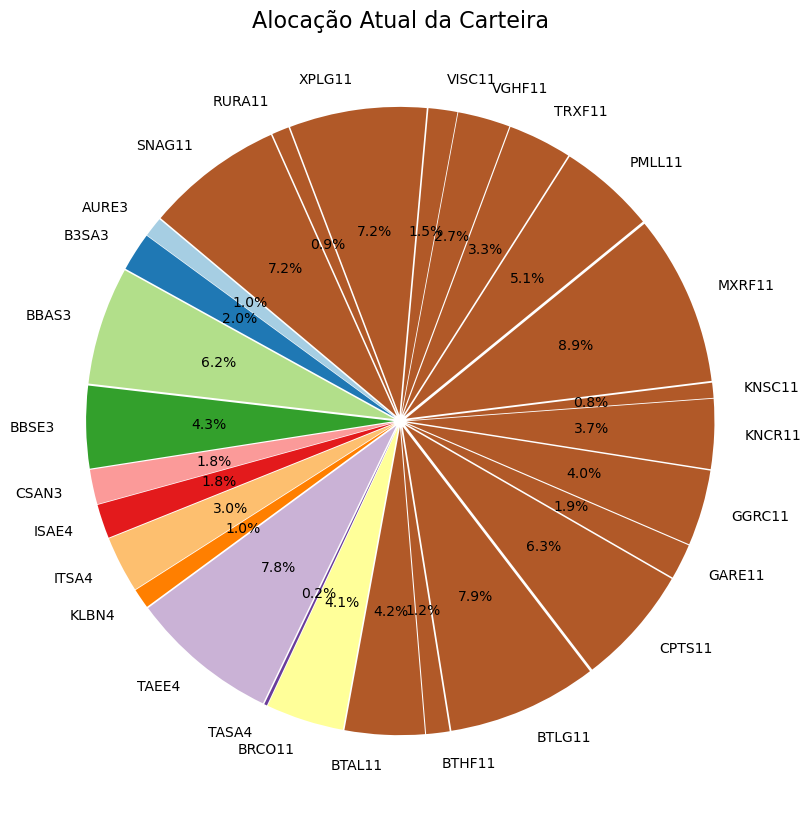

In [5]:
if not df.empty:
    # Preparar dados para o gráfico
    pie_data = df[df['Current_Value'] > 0].copy()
    
    plt.figure(figsize=(10, 10))
    # Usar cores variadas
    colors = plt.cm.Paired(range(len(pie_data)))
    
    plt.pie(pie_data['Current_Value'], 
            labels=pie_data['Ticker'], 
            autopct='%1.1f%%', 
            startangle=140,
            explode=[0.02]*len(pie_data), # Leve separação
            colors=colors)
            
    plt.title('Alocação Atual da Carteira', fontsize=16)
    plt.show()

### 6. Script de Automação (`.bat`)
O arquivo abaixo é agendado no Windows Task Scheduler para rodar todo dia às 18h.

In [ ]:
bat_content = """
@echo off
chcp 65001 > nul
echo ==============================================
echo      ATUALIZADOR DE INVESTIMENTOS B3
echo ==============================================
echo.
echo Procurando arquivos e conectando a internet...
echo.

python "%~dp0investment_dashboard.py"

echo.
echo ==============================================
if %ERRORLEVEL% EQU 0 (
    echo     ATUALIZACAO CONCLUIDA COM SUCESSO!
) else (
    echo     OCORREU UM ERRO. LEIA ACIMA.
)
echo ==============================================
echo.
pause
"""
print(bat_content)